In [1]:
__author__ = 'racah'
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from nbfinder import NotebookFinder
import sys
import os
sys.meta_path.append(NotebookFinder())
%matplotlib inline

In [2]:
def load_data(
    bg_path = [line.rstrip() for line in open('../config/BgFileListAug16.txt')],
    sig_path=[line.rstrip() for line in open('../config/SignalFileListAug16.txt')],
    group_name='CollectionTree',
    branches=['CaloCalTopoClustersAuxDyn.calPhi', 'CaloCalTopoClustersAuxDyn.calEta','CaloCalTopoClustersAuxDyn.calE'],
    num_events=1000,
    preprocess=True,
    bins=100,
    dataset_name='histo', 
    type='root'):
  
    assert num_events % 2 == 0, "why an odd number for num_events?!, even please"
    num_each = num_events / 2

    if type == 'hdf':
        bgdf = pd.read_hdf(bg_path, group_name)
        sigdf = pd.read_hdf(sig_path, group_name)
        x_bg = bgdf[dataset_name][:num_each]
        x_sig = sigdf[dataset_name][:num_each]
        #background first
        x_concat = np.hstack((x_bg, x_sig))
        dim_x, dim_y = x_bg[0].shape
        x = np.zeros((num_events ,dim_x, dim_y ))
        for i in range(num_events):
            x[i] = x_concat[i]
        # add a channel size of 1 as a place holder
        x = np.expand_dims(x,axis=1)
        
    if type == 'root':
        sys.path.append('/global/homes/w/wbhimji/cori-envs/nersc-rootpy/lib/python2.7/site-packages/')
        import ROOT
        import rootpy
        import root_numpy as rnp
        bgarray = rnp.root2array(bg_path, treename=group_name,branches=branches, start=0, stop=num_each)
        bgdf = pd.DataFrame.from_records(bgarray)
        sigarray = rnp.root2array(sig_path, treename=group_name, branches=branches, start=0, stop=num_each)
        sigdf = pd.DataFrame.from_records(sigarray)
        x_bg = np.zeros((num_each,1,bins, bins ))
        x_sig = np.zeros((num_each,1,bins, bins ))
        #num events is now num each
        for i in range(num_each):
            phi, eta, E =  bgdf['CaloCalTopoClustersAuxDyn.calPhi'][i],bgdf['CaloCalTopoClustersAuxDyn.calEta'][i],\
                bgdf['CaloCalTopoClustersAuxDyn.calE'][i]
            x_bg[i] = np.histogram2d(phi,eta, bins=bins, weights=E, range=[[-3.14, 3.14],[-2.5, 2.5]])[0]
            phi, eta, E =  sigdf['CaloCalTopoClustersAuxDyn.calPhi'][i],sigdf['CaloCalTopoClustersAuxDyn.calEta'][i],\
                sigdf['CaloCalTopoClustersAuxDyn.calE'][i]
            x_sig[i] = np.histogram2d(phi,eta, bins=bins, weights=E, range=[[-3.14, 3.14],[-2.5, 2.5]])[0]

        #background first
        x = np.vstack((x_bg, x_sig))      
    
    # 1 means signal, 0 means background
    y = np.zeros((num_events,)).astype('int32')
    #make the last half signal label
    y[num_each:] = 1


    #shuffle examples
    rng = np.random.RandomState(seed=9)

    inds = np.arange(num_events)

    rng.shuffle(inds)

    #split train, val, test
    tr_inds = inds[:int(0.6*num_events)] 
    val_inds = inds[int(0.6*num_events):int(0.8*num_events)]
    te_inds = inds[int(0.8*num_events):]
    
    x_tr, y_tr, x_val, y_val, x_te, y_te = x[tr_inds], y[tr_inds], \
                                           x[val_inds], y[val_inds], \
                                           x[te_inds], y[te_inds]
    if preprocess:
        '''a type of sparse preprocessing, which scales everything between -1 and 1 without losing sparsity'''
        #only calculate the statistic using training set
        max_abs=np.abs(x_tr).max(axis=(0,1,2,3))
        
        #then scale all sets
        x_tr /= max_abs
        x_te /= max_abs
        x_val /= max_abs
    
        
 
    
    return x_tr, y_tr, x_val, y_val, x_te, y_te
    

Welcome to ROOTaaS 6.06/06


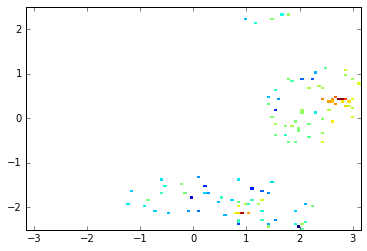

In [3]:
if __name__=="__main__":
    data = load_data()
    x,y,xv,yv,x_te,y_te = data
    plt.imshow(np.log10(x[10][0]),extent=[-3.15, 3.15, -2.5, 2.5], interpolation='none',aspect='auto', origin='low')
